### CSCI 4270 - Computational Vision
### HW 4 - Part 2
#### Ansor Kasimov - 3/19/2024

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

%matplotlib inline

In [45]:
def is_image(fn):
    '''
    Check if a filename 'fn' is an image file
    '''

    extensions = ['.jpg', '.jpeg', '.png']

    return any(fn.lower().endswith(ext) for ext in extensions)

def find_images_in_folder(folder_path, verbose=False):
    '''
    Get all the valid images in folder 'folder_path'
    '''

    full_image_paths = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if os.path.isfile(file_path) and is_image(filename):
            try:
                _ = Image.open(file_path)
                full_image_paths.append(file_path)

                if verbose:
                    print(f"Read image: {file_path}")
            except Exception as e:
                print(f"Error failed to read {filename}: {e}")

    return full_image_paths

In [46]:
'''
Encapsulate image data into a 'Dataset' class

The mean and standard deviation for the RGB values are
empirically derived from the ImageNet dataset
'''

class HW4_Dataset(Dataset):
    def __init__(self, path, class_names, new_size=None, verbose=False):
        self.full_image_paths = []
        self.class_names = class_names
        self.gt_class_idx = []

        '''
        Label images with their corresponding class index
        '''

        for idx, label in enumerate(class_names):
            folder_path = os.path.join(path, label)
            image_paths = find_images_in_folder(folder_path, verbose)
            self.full_image_paths += image_paths
            self.gt_class_idx += [idx] * len(image_paths)

        if new_size is not None:
            self.transform = transforms.Compose([
                transforms.Resize(new_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.full_image_paths)

    def __getitem__(self, idx):
        '''
        Get image and corresponding label at index 'idx'

        A one-hot vector is returned instead of a label
        index since it is faster to compute with whilst
        training a model
        '''

        fp = self.full_image_paths[idx]

        one_hot_class_idx = [0 for _ in range(len(class_names))]
        one_hot_class_idx[self.gt_class_idx[idx]] = 1
        one_hot_class_idx = torch.tensor(one_hot_class_idx)

        im = Image.open(fp)
        im = self.transform(im)

        return im, one_hot_class_idx

class_names = ['grass', 'ocean', 'redcarpet', 'road', 'wheatfield']

new_size = 60   # This reduces the original 240x360 images to 60x90.  Setting it to 240 leaves the images unchanged
#new_size = None # Setting new_size to None keeps the original image size.
verbose = False

# Form all three datasets.
train_dataset = HW4_Dataset('data/train', class_names, new_size=new_size, verbose=verbose)
valid_dataset = HW4_Dataset('data/valid', class_names, new_size=new_size, verbose=verbose)
test_dataset = HW4_Dataset('data/test', class_names, new_size=new_size, verbose=verbose)

The validation dataset has 750 images
After the shuffle the 0th image has class index tensor([0, 1, 0, 0, 0])
Image shape is (60, 90, 3)


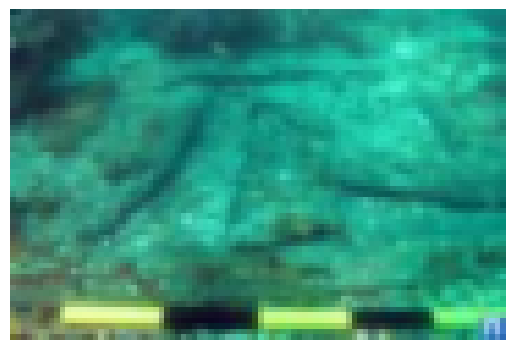

tensor([0, 1, 0, 0, 0])


In [47]:
'''
Explore the constructed dataset
'''

# Find and output the number of images
n = len(valid_dataset)
print(f'The validation dataset has {n} images')

# Randomly shuffle the image indices
indices = list(range(n))
random.shuffle(indices)

# Get the image and the class id of the 0th image after the shuffle.
im, class_idx = valid_dataset[indices[0]]
print(f'After the shuffle the 0th image has class index {class_idx}')

# Convert the image from an array back to a numpy 3d array
im_np = im.numpy().transpose((1, 2, 0))
print(f'Image shape is {im_np.shape}')

# Before displaying the image rescale the intensities to be between 0 and 1
im_min = im_np.min()
im_max = im_np.max()
im_np = (im_np - im_min) / (im_max - im_min)

# Display the image
plt.imshow(im_np)
plt.axis('off')
plt.show()
print(class_idx)

5 random images:


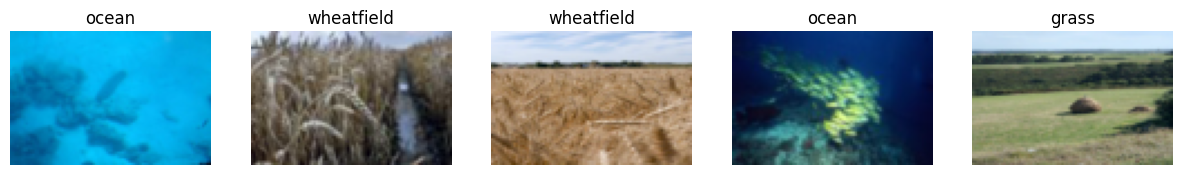


Within the training set: 700 pictures have a grass background,
                         700 pictures have a ocean background,
                         700 pictures have a redcarpet background,
                         700 pictures have a road background, and 
                         700 pictures have a wheatfield background

Within the validation set: 150 pictures have a grass background,
                           150 pictures have a ocean background,
                           150 pictures have a redcarpet background,
                           150 pictures have a road background, and 
                           150 pictures have a wheatfield background

Within the testing set: 150 pictures had a grass background,
                        150 pictures have a ocean background,
                        150 pictures have a redcarpet background,
                        150 pictures have a road background, and 
                        150 pictures have a wheatfield background

All three s

In [48]:
'''
Display a random selection of images with their corresponding
labels

Then show how many images from the training and testing set
belong to each label
'''

all_images, all_labels = [], []
x, y, z = len(train_dataset), len(valid_dataset), len(test_dataset)

for i in range(x + y + z):
    if i < x:
        im, label = train_dataset[i]
    elif i < x + y:
        im, label = valid_dataset[i - x]
    else:
        im, label = test_dataset[i - x - y]

    im = im.numpy().transpose((1, 2, 0))
    im = (im - im.min()) / (im.max() - im.min())

    label = torch.nonzero(label).item()

    all_images.append(im)
    all_labels.append(label)

random_images, random_labels = [], []

for _ in range(5):
    random_index = np.random.randint(0, x + y + z)
    random_images.append(all_images[random_index])
    random_labels.append(all_labels[random_index])

print('5 random images:')

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(random_images[i])
    axes[i].set_title(class_names[random_labels[i]])
    axes[i].axis('off')

plt.show()

print()

label_count_train = np.bincount(all_labels[:x])
label_count_valid = np.bincount(all_labels[x:x + y])
label_count_test = np.bincount(all_labels[x + y:x + y + z])

print(f'''Within the training set: {label_count_train[0]} pictures have a grass background,
                         {label_count_train[1]} pictures have a ocean background,
                         {label_count_train[2]} pictures have a redcarpet background,
                         {label_count_train[3]} pictures have a road background, and 
                         {label_count_train[4]} pictures have a wheatfield background\n''')

print(f'''Within the validation set: {label_count_valid[0]} pictures have a grass background,
                           {label_count_valid[1]} pictures have a ocean background,
                           {label_count_valid[2]} pictures have a redcarpet background,
                           {label_count_valid[3]} pictures have a road background, and 
                           {label_count_valid[4]} pictures have a wheatfield background\n''')

print(f'''Within the testing set: {label_count_test[0]} pictures had a grass background,
                        {label_count_test[1]} pictures have a ocean background,
                        {label_count_test[2]} pictures have a redcarpet background,
                        {label_count_test[3]} pictures have a road background, and 
                        {label_count_test[4]} pictures have a wheatfield background\n''')

print('All three sets have uniform frequency for each background: 0.2')